In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from lmfit import Model, Parameter, report_fit
from scipy.optimize import curve_fit
from copy import copy
from utils.physics import *
from utils.epg import *
import icecream as ic

In [2]:
M = 0.938272081
me = 0.5109989461 * 0.001
ebeam = 10.604
pbeam = np.sqrt(ebeam * ebeam - me * me)
beam = [0, 0, pbeam]
target = [0, 0, 0]

In [18]:
file_name = "/Users/sangbaek/Dropbox (MIT)/data/default.dat"
epg = epgFromLund(file_name, 4*10**6)
dvcs = epg.getDVCS()
file_name = "/Users/sangbaek/Dropbox (MIT)/data/gpd101.dat"
epg = epgFromLund(file_name, 4*10**6)
dvcs2 = epg.getDVCS()

On event 0.0
On event 100000.0
On event 200000.0
On event 300000.0
On event 400000.0
On event 500000.0
On event 600000.0
On event 700000.0
On event 800000.0
On event 900000.0
On event 0.0
On event 100000.0
On event 200000.0
On event 300000.0
On event 400000.0
On event 500000.0
On event 600000.0
On event 700000.0
On event 800000.0
On event 900000.0


In [5]:
epg.setDVCSvars()

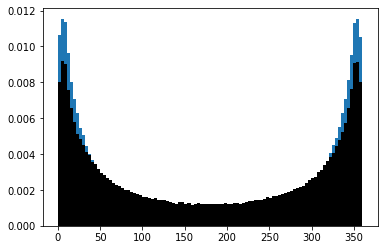

In [16]:
fig, ax = plt.subplots()
ax.hist(dvcs["phi2"], bins =101, density = True)
ax.hist(dvcs2["phi2"], bins =101, density = True, color ='k')
plt.show()

In [122]:
# read all data in one shot
with open(file_name,"r") as file:
    data = file.read()

In [123]:
partArray = []

In [124]:
# go through each row
txtlst = data.split("\n")
for ind, line in enumerate(txtlst):
    if ind %400000 == 0:
        print("On event {}".format(ind/4))
    if ind % 4 == 0:
        header = line
        eleLine = txtlst[ind+1]
        eleQuantities = eleLine.split()
        Epx = eleQuantities[6]
        Epy = eleQuantities[7]
        Epz = eleQuantities[8]
        proLine = txtlst[ind+2]
        proQuantities = proLine.split()
        Ppx = proQuantities[6]
        Ppy = proQuantities[7]
        Ppz = proQuantities[8]
        gamLine = txtlst[ind+3]
        gamQuantities = gamLine.split()
        Gpx = gamQuantities[6]
        Gpy = gamQuantities[7]
        Gpz = gamQuantities[8]
        partArray.append([float(Epx), float(Epy), float(Epz), float(Ppx), float(Ppy), float(Ppz), float(Gpx), float(Gpy), float(Gpz)])

On event 0.0
On event 100000.0
On event 200000.0
On event 300000.0
On event 400000.0
On event 500000.0
On event 600000.0
On event 700000.0
On event 800000.0
On event 900000.0


In [125]:
df_epg = pd.DataFrame(partArray, columns = ["Epx", "Epy", "Epz", "Ppx", "Ppy", "Ppz", "Gpx", "Gpy", "Gpz"])

In [165]:
beam = [0, 0, pbeam]
target = [0, 0, 0]
ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

In [127]:
#energy
df_epg['Ee'] = np.sqrt(me**2+df_epg["Epx"]**2+df_epg["Epy"]**2+df_epg["Epz"]**2)
df_epg['Pe'] = np.sqrt(M**2+df_epg["Ppx"]**2+df_epg["Ppy"]**2+df_epg["Ppz"]**2)
df_epg['Ge'] = np.sqrt(df_epg["Gpx"]**2+df_epg["Gpy"]**2+df_epg["Gpz"]**2)

In [128]:
#binning kinematics
df_epg['Q2'] = -((ebeam-df_epg['Ee'])**2-df_epg['Epx']**2-df_epg['Epy']**2-(pbeam-df_epg['Epz'])**2)
df_epg['xB'] = df_epg['Q2']/2.0/M/(ebeam-df_epg['Ee'])
df_epg['nu'] = (ebeam-df_epg['Ee'])
VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
df_epg['t1'] = 2*M*(df_epg['Pe']-M)
costheta = cosTheta(VGS, gam)
df_epg['t2'] = (M*df_epg['Q2']+2*M*df_epg['nu']*(df_epg['nu']-np.sqrt(df_epg['nu']*df_epg['nu']+df_epg['Q2'])*costheta))/(M+df_epg['nu']-np.sqrt(df_epg['nu']*df_epg['nu']+df_epg['Q2'])*costheta)
df_epg['W'] = np.sqrt((ebeam+M-df_epg['Ee'])**2-df_epg['Epx']**2-df_epg['Epy']**2-(pbeam-df_epg['Epz'])**2)

In [129]:
v3l = cross(beam, ele)
v3h = cross(pro, VGS)
v3g = cross(VGS, gam)

In [130]:
df_epg['phi1'] = angle(v3l, v3h)
df_epg['phi1'] = np.where(dot(v3l, pro)>0, 360.0 - df_epg['phi1'], df_epg['phi1'])

In [131]:
df_epg['phi2'] = angle(v3l, v3g)
df_epg['phi2'] = np.where(dot(VGS, cross(v3l, v3g))<0, 360.0 - df_epg['phi2'], df_epg['phi2'])

In [132]:
#exclusivity variables
df_epg['MM2_epg'] = (-M-ebeam+df_epg["Ee"]+df_epg["Pe"]+df_epg["Ge"])**2 - (df_epg["Epx"]+df_epg["Ppx"]+df_epg["Gpx"])**2 - \
(df_epg["Epy"]+df_epg["Ppy"]+df_epg["Gpy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Ppz"]+df_epg["Gpz"]) **2
df_epg['ME_epg'] = (M+ebeam-df_epg["Ee"]-df_epg["Pe"]-df_epg["Ge"])
df_epg['MM2_ep'] = (-M-ebeam+df_epg["Ee"]+df_epg["Pe"])**2 - (df_epg["Epx"]+df_epg["Ppx"])**2 - \
(df_epg["Epy"]+df_epg["Ppy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Ppz"]) **2
df_epg['MM2_eg'] = (-M-ebeam+df_epg["Ee"]+df_epg["Ge"])**2 - (df_epg["Epx"]+df_epg["Gpx"])**2 - \
(df_epg["Epy"]+df_epg["Gpy"])**2 -(-pbeam+df_epg["Epz"]+df_epg["Gpz"]) **2
df_epg['MPt'] = np.sqrt((df_epg["Epx"]+df_epg["Ppx"]+df_epg["Gpx"])**2 + \
(df_epg["Epy"]+df_epg["Ppy"]+df_epg["Gpy"])**2)
df_epg['coneAngle'] = angle(ele, gam)#180.*/np.pi*np.arccos((df_epg["Epx"]*df_epg["Gpx"]+df_epg["Epy"]*df_epg["Gpy"]+df_epg["Epz"]*df_epg["Gpz"])/np.sqrt(df_epg["Epx"]*df_epg["Epx"]+df_epg["Epy"]*df_epg["Epy"]+df_epg["Epz"]*df_epg["Epz"])/np.sqrt(df_epg["Gpx"]*df_epg["Gpx"]+df_epg["Gpy"]*df_epg["Gpy"]+df_epg["Gpz"]*df_epg["Gpz"]))
VmissG = [-df_epg["Epx"]-df_epg["Ppx"], -df_epg["Epy"]-df_epg["Ppy"], pbeam-df_epg["Epz"]-df_epg["Ppz"]]
# df_epg['reconGam'] = angle(gam, VmissG)
Vhadr = cross(pro, VGS)
Vhad2 = cross(VGS, gam)
# df_epg['coplanarity'] = angle(Vhadr, Vhad2)

In [116]:
%matplotlib
fig, ax = plt.subplots()
cmap = copy(plt.cm.get_cmap("jet"))
ax.hist(df_epg["phi2"], bins = 101)
# ax.hist2d(df_epg["xB"], df_epg["Q2"], cmin = 1 , cmap = cmap, bins = [101, 101])
# plt.xlim([-0.5,1.2])
# print(len(df_sym))
# print((0.1349768/df_sym["Mpi0"]).mean())
# ax.hist2d(df_sym["Ge"], (0.1349768/df_sym["Mpi0"])**2-1, bins = [51, 51], cmap = cmap, cmin = 1)
# ax.hist2d(df_sym["Ge"], df_sym["Mpi0"]/0.1349768, bins = [51, 51], cmap = cmap, cmin = 1)
# plt.xlabel("Ge")
# plt.ylabel("reconstructed pi0 mass")
# ax.hist(df_dvpi0["Mpi0"], bins = 101)
plt.show()


Using matplotlib backend: MacOSX


In [117]:
eleTheta = getTheta(ele)
eleTheta.hist(bins=50, density =1)
proTheta = getTheta(pro)
proTheta.hist(bins=50, density =1)
gamTheta = getTheta(gam)
gamTheta.hist(bins=50, density =1)

<AxesSubplot:>

In [70]:
xB_edges = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,\
			0.45, 0.5, 0.55, 0.6, 0.7, 0.85, 1]
Q2_edges = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0,\
			4.5, 5.0, 5.5, 6.0, 7.0, 8.0, 9.0, 12.]
t_edges = [0.09, 0.15, 0.20, 0.3, 0.4, 0.60, 1.00, 1.5, 2.0]
phi_edges = np.linspace(0, 360, 31)


In [95]:
%matplotlib
Q2ind = 4
xBind = 4
tind = 4

fig, axs = plt.subplots()
binQ2lower = df_epg["Q2"] > Q2_edges[Q2ind]
binQ2upper = df_epg["Q2"] < Q2_edges[Q2ind + 1]
binxBlower = df_epg["xB"] > xB_edges[xBind]
binxBupper = df_epg["xB"] < xB_edges[xBind + 1]
bintlower = df_epg["t2"] > t_edges[tind]
bintupper = df_epg["t2"] < t_edges[tind + 1]
plotter = df_epg[binQ2lower & binQ2upper &
                         binxBlower & binxBupper & bintlower & bintupper]
# axs.set_xticks([])
axs.set_yticks([])
# axs.set_xticklabels([])
axs.set_yticklabels([])
# plt.setp(axs.get_xticklabels(), visible=False)
plt.setp(axs.get_yticklabels(), visible=False)
axs.hist(plotter["phi2"],
                bins=phi_edges,
                linewidth=0.5,
                histtype='stepfilled',
                facecolor='none',
                edgecolor='k')
axs.set_title("")
# axs.xaxis.set_visible(False)
axs.yaxis.set_visible(False)
axs.set_ylim([1, 5000])
axs.set_yscale('log')

Using matplotlib backend: MacOSX


In [166]:
df_epg["Ptheta"] = 180/np.pi*getTheta(pro)
df_epg["Gtheta"] = 180/np.pi*getTheta(gam)

In [98]:
df_epgCDFT = df_epg[(df_epg["Ptheta"]>45) & (df_epg["Gtheta"]<5)]

In [100]:
df_epgCDFT.hist("phi2")

array([[<AxesSubplot:title={'center':'phi2'}>]], dtype=object)

In [101]:
df_dvcsOnly = df_epg

In [167]:
df_bhOnly = df_epg

In [134]:
df_dvcs = df_epg

In [137]:
df_dvcsOnly.hist("phi2")
df_bhOnly.hist("phi2")
df_dvcs.hist("phi2")

array([[<AxesSubplot:title={'center':'phi2'}>]], dtype=object)

In [220]:
hist1, bins1 = np.histogram(df_dvcsOnlyCDFT["phi2"], bins=np.linspace(0, 360, 361))
hist2, bins2 = np.histogram(df_bhOnlyCDFT["phi2"], bins=np.linspace(0, 360, 361))
hist3, bins3 = np.histogram(df_dvcsCDFT["phi2"], bins=np.linspace(0, 360, 361))

In [169]:
df_dvcsOnlyCDFT = df_dvcsOnly[(df_dvcsOnly["Ptheta"]>45) & (df_dvcsOnly["Gtheta"]<5)]
df_bhOnlyCDFT = df_bhOnly[(df_bhOnly["Ptheta"]>45) & (df_bhOnly["Gtheta"]<5)]
df_dvcsCDFT = df_dvcs[(df_dvcs["Ptheta"]>45) & (df_dvcs["Gtheta"]<5)]

In [222]:
%matplotlib
f=0.32
fig, ax = plt.subplots()
ax.plot(hist2)
plt.show()

Using matplotlib backend: MacOSX


In [207]:
df_bhOnlyCDFT.hist(column="phi2", weights=2+0*df_bhOnlyCDFT["Epx"])

array([[<AxesSubplot:title={'center':'phi2'}>]], dtype=object)

In [183]:
f=0.35
f*hist1+(1-f)*hist2-hist3

array([ -726.7 , -5890.4 , -2625.8 , -1034.3 ,  -308.2 ,   224.35,
         541.55,   886.8 ,   827.2 ,   750.15,   597.65,   760.25,
         949.15,   444.65,   752.15,   891.95,   738.7 ,   701.05,
         587.05,   512.1 ,   817.75,   767.6 ,   918.45,   798.5 ,
         882.3 ,   896.9 ,  1182.25,   654.5 ,   748.1 ,   661.4 ,
         659.  ,   181.3 ,  -855.4 , -2579.55, -5092.25,  -220.2 ])

In [164]:
df_epg = df_dvcs

In [230]:
%matplotlib
Q2ind = 1
xBind = 1
tind = 1
fig, axs = plt.subplots()
binQ2lower = df_dvcsOnlyCDFT["Q2"] > Q2_edges[Q2ind]
binQ2upper = df_dvcsOnlyCDFT["Q2"] < Q2_edges[Q2ind + 1]
binxBlower = df_dvcsOnlyCDFT["xB"] > xB_edges[xBind]
binxBupper = df_dvcsOnlyCDFT["xB"] < xB_edges[xBind + 1]
bintlower = df_dvcsOnlyCDFT["t2"] > t_edges[tind]
bintupper = df_dvcsOnlyCDFT["t2"] < t_edges[tind + 1]
plotter = df_dvcsOnlyCDFT[binQ2lower & binQ2upper &
                         binxBlower & binxBupper & bintlower & bintupper]
# axs.set_xticks([])
axs.set_yticks([])
# axs.set_xticklabels([])
axs.set_yticklabels([])
# plt.setp(axs.get_xticklabels(), visible=False)
plt.setp(axs.get_yticklabels(), visible=False)
axs.hist(plotter["phi2"],
                bins=phi_edges,
                linewidth=0.5,
                histtype='stepfilled',
                facecolor='none',
                edgecolor='k')
axs.set_title("")
# axs.xaxis.set_visible(False)
axs.yaxis.set_visible(False)
axs.set_ylim([1, 5000])
axs.set_yscale('log')

Using matplotlib backend: MacOSX
